In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error

In [73]:
data = pd.read_csv('../data/external/heart_failure_clinical_records_dataset.csv', low_memory=False)

In [74]:
print("Initial Data Information:")
data.info()

print("\nSummary Statistics:\n", data.describe())
print("\nMissing Values Per Column:\n", data.isna().sum())

Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 

In [75]:
data_cleaned = data.apply(pd.to_numeric, errors='coerce').fillna(0)  # Convert non-numeric to NaN, then fill NaNs

In [76]:
data_encoded = pd.get_dummies(data, columns=['sex', 'smoking'], drop_first=True)

In [77]:
dataset_full = data_encoded.copy()
dataset_full

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT,sex_1,smoking_1
0,75.0,0,582,0,20,1,265000.00,1.9,130,4,1,True,False
1,55.0,0,7861,0,38,0,263358.03,1.1,136,6,1,True,False
2,65.0,0,146,0,20,0,162000.00,1.3,129,7,1,True,True
3,50.0,1,111,0,20,0,210000.00,1.9,137,7,1,True,False
4,65.0,1,160,1,20,0,327000.00,2.7,116,8,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,270,0,True,True
295,55.0,0,1820,0,38,0,270000.00,1.2,139,271,0,False,False
296,45.0,0,2060,1,60,0,742000.00,0.8,138,278,0,False,False
297,45.0,0,2413,0,38,0,140000.00,1.4,140,280,0,True,True


In [78]:
# Define feature sets for different datasets
medical_features = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
                    'ejection_fraction', 'high_blood_pressure', 'platelets', 
                    'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']
dataset_medical = data[medical_features]

dataset_medical

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [79]:
lifestyle_features = ['age', 'sex', 'smoking', 'diabetes', 'time', 'DEATH_EVENT']
dataset_lifestyle = data[lifestyle_features]

dataset_lifestyle

,age,sex,smoking,diabetes,time,DEATH_EVENT
0,75.0,1,0,0,4,1
1,55.0,1,0,0,6,1
2,65.0,1,1,0,7,1
3,50.0,1,0,0,7,1
4,65.0,0,0,1,8,1
...,...,...,...,...,...,...
294,62.0,1,1,1,270,0
295,55.0,0,0,0,271,0
296,45.0,0,0,1,278,0
297,45.0,1,1,0,280,0


In [80]:
biochemical_features = ['serum_creatinine', 'serum_sodium', 'platelets', 
                        'ejection_fraction', 'time', 'DEATH_EVENT']
dataset_biochemical = data[biochemical_features]

dataset_biochemical

,serum_creatinine,serum_sodium,platelets,ejection_fraction,time,DEATH_EVENT
0,1.9,130,265000.00,20,4,1
1,1.1,136,263358.03,38,6,1
2,1.3,129,162000.00,20,7,1
3,1.9,137,210000.00,20,7,1
4,2.7,116,327000.00,20,8,1
...,...,...,...,...,...,...
294,1.1,143,155000.00,38,270,0
295,1.2,139,270000.00,38,271,0
296,0.8,138,742000.00,60,278,0
297,1.4,140,140000.00,38,280,0


In [81]:
# Full dataset
X = dataset_full.drop('DEATH_EVENT', axis=1)
y = dataset_full['DEATH_EVENT']

In [82]:
# Convert to NumPy arrays
X_np = X.to_numpy().astype(float)  # Ensuring all elements are float
y_np = y.to_numpy().astype(float)

# Adding a constant for intercept in StatsModels
X_with_const = sm.add_constant(X_np)

# Perform OLS regression with StatsModels
ols_model = sm.OLS(y_np, X_with_const).fit()
print("\nOrdinary Least Squares (OLS) Summary (StatsModels):")
ols_model.summary()


Ordinary Least Squares (OLS) Summary (StatsModels):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     17.04
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           2.35e-27
Time:                        11:50:04   Log-Likelihood:                -115.90
No. Observations:                 299   AIC:                             257.8
Df Residuals:                     286   BIC:                             305.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6636      0.695      2.392      0.017       0.295       3.032
x1             0.0058      0.002      3.088      0.002       0.002       0.009
x2            -0.0028      0.044     -0.062      0.950      -0.090       0.085
x3          3.427e-05   2.25e-05      1.525      0.128   -9.96e-06    7.85e-05
x4             0.0193      0.044      0.437      0.662      -0.068       0.106
x5            -0.0098      0.002     -5.333      0.000      -0.013      -0.006
x6            -0.0143      0.046     -0.313      0.754      -0.104       0.076
x7          -8.37e-08   2.21e-07     -0.379      0.705   -5.18e-07    3.51e-07
x8             0.0853      0.021      4.017      0.000       0.043       0.127
x9            -0.0076      0.005     -1.513      0.131      -0.017       0.002
x10           -0.0027      0.000     -9.415      0.000      -0.003      -0.002
x11           -0.0637      0.051     -1.247      0.214      -0.164       0.037
x12           -0.0057      0.051     -0.112      0.911      -0.106       0.095
==============================================================================
Omnibus:                       10.068   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.014
Skew:                           0.306   Prob(JB):                       0.0182
Kurtosis:                       2.483   Cond. No.                     9.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
linear_model = LinearRegression()
linear_model.fit(X, y)
print("\nLinear Regression Coefficients (Scikit-Learn):")
pd.Series(linear_model.coef_, index=X.columns)


Linear Regression Coefficients (Scikit-Learn):


age                         5.766578e-03
anaemia                    -2.765880e-03
creatinine_phosphokinase    3.426613e-05
diabetes                    1.927520e-02
ejection_fraction          -9.833650e-03
high_blood_pressure        -1.429674e-02
platelets                  -8.370305e-08
serum_creatinine            8.526866e-02
serum_sodium               -7.599145e-03
time                       -2.732842e-03
sex_1                      -6.368536e-02
smoking_1                  -5.732644e-03
dtype: float64

In [84]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X, y)
print("\nLasso Regression Coefficients (Scikit-Learn):")
pd.Series(lasso_model.coef_, index=X.columns)


Lasso Regression Coefficients (Scikit-Learn):


age                         5.656422e-03
anaemia                     0.000000e+00
creatinine_phosphokinase    3.085116e-05
diabetes                    0.000000e+00
ejection_fraction          -8.863551e-03
high_blood_pressure        -0.000000e+00
platelets                  -8.681063e-08
serum_creatinine            0.000000e+00
serum_sodium               -6.512258e-03
time                       -2.870765e-03
sex_1                      -0.000000e+00
smoking_1                  -0.000000e+00
dtype: float64

In [85]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)
print("\nRidge Regression Coefficients (Scikit-Learn):")
pd.Series(ridge_model.coef_, index=X.columns)


Ridge Regression Coefficients (Scikit-Learn):


age                         5.764782e-03
anaemia                    -2.650592e-03
creatinine_phosphokinase    3.423952e-05
diabetes                    1.907711e-02
ejection_fraction          -9.827757e-03
high_blood_pressure        -1.401072e-02
platelets                  -8.301885e-08
serum_creatinine            8.497968e-02
serum_sodium               -7.614093e-03
time                       -2.732909e-03
sex_1                      -6.251580e-02
smoking_1                  -6.182457e-03
dtype: float64

In [86]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X, y)
print("\nElasticNet Regression Coefficients (Scikit-Learn):")
pd.Series(elastic_net_model.coef_, index=X.columns)


ElasticNet Regression Coefficients (Scikit-Learn):


age                         5.627340e-03
anaemia                     0.000000e+00
creatinine_phosphokinase    3.161921e-05
diabetes                    0.000000e+00
ejection_fraction          -9.144551e-03
high_blood_pressure        -0.000000e+00
platelets                  -6.695110e-08
serum_creatinine            3.578402e-02
serum_sodium               -7.497130e-03
time                       -2.802329e-03
sex_1                      -0.000000e+00
smoking_1                  -0.000000e+00
dtype: float64

In [87]:
def cross_validate_and_evaluate(dataset, model_name, model):
    X = dataset.drop('DEATH_EVENT', axis=1)
    y = dataset['DEATH_EVENT']
    
    # Applying KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    predictions = cross_val_predict(model, X, y, cv=kf)
    
    # Calculate RMSE
    rmse = root_mean_squared_error(y, predictions)
    print(f"{model_name} RMSE: {rmse:.3f}")

    # Using cross_val_score for evaluation
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    print(f"{model_name} RMSE Scores: {-scores}\n")
    return rmse

In [88]:
# Cross-validation for all models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1),
    'ElasticNet Regression': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

In [89]:
dataset_names = ['Full Dataset', 'Medical Dataset', 'Lifestyle Dataset', 'Biochemical Dataset']
datasets = [dataset_full, dataset_medical, dataset_lifestyle, dataset_biochemical]
rmse_results = {name: [] for name in models.keys()}

In [90]:
print("\nCross-validation Results:")
for model_name, model in models.items():
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[i]
        print(f"\nEvaluating {model_name} on {dataset_name}")
        rmse = cross_validate_and_evaluate(dataset, model_name, model)
        rmse_results[model_name].append(rmse)


Cross-validation Results:

Evaluating Linear Regression on Full Dataset
Linear Regression RMSE: 0.376
Linear Regression RMSE Scores: [0.35639298 0.41494686 0.39698579 0.36119693 0.34610928]


Evaluating Linear Regression on Medical Dataset
Linear Regression RMSE: 0.376
Linear Regression RMSE Scores: [0.35639298 0.41494686 0.39698579 0.36119693 0.34610928]


Evaluating Linear Regression on Lifestyle Dataset
Linear Regression RMSE: 0.399
Linear Regression RMSE Scores: [0.35358496 0.43019424 0.44819423 0.40009275 0.35064911]


Evaluating Linear Regression on Biochemical Dataset
Linear Regression RMSE: 0.373
Linear Regression RMSE Scores: [0.36082603 0.40431253 0.37189786 0.36290868 0.3610357 ]


Evaluating Lasso Regression on Full Dataset
Lasso Regression RMSE: 0.381
Lasso Regression RMSE Scores: [0.35406353 0.41628641 0.41887776 0.37960345 0.32550803]


Evaluating Lasso Regression on Medical Dataset
Lasso Regression RMSE: 0.381
Lasso Regression RMSE Scores: [0.35406353 0.41628641 0.4188

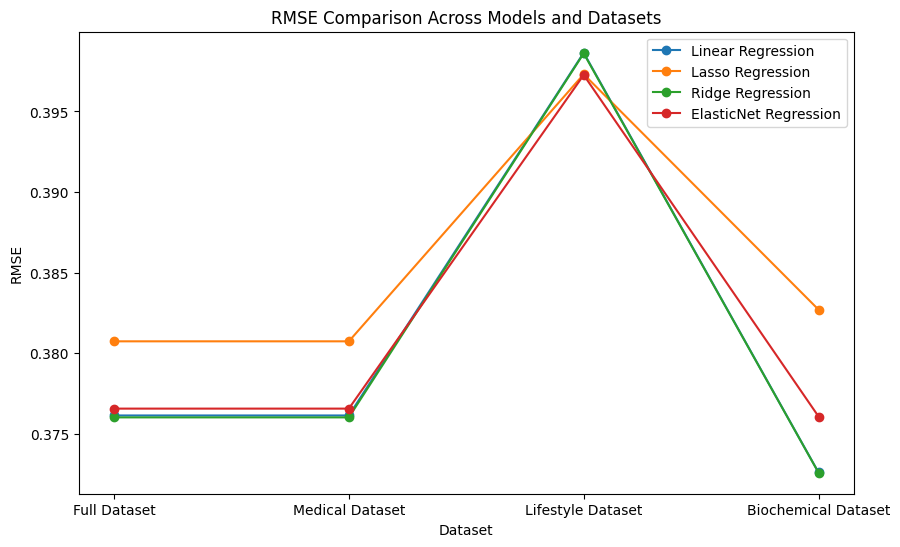

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))
for model_name, rmse_scores in rmse_results.items():
    ax.plot(dataset_names, rmse_scores, marker='o', label=model_name)

ax.set_title('RMSE Comparison Across Models and Datasets')
ax.set_xlabel('Dataset')
ax.set_ylabel('RMSE')
ax.legend()
plt.show()

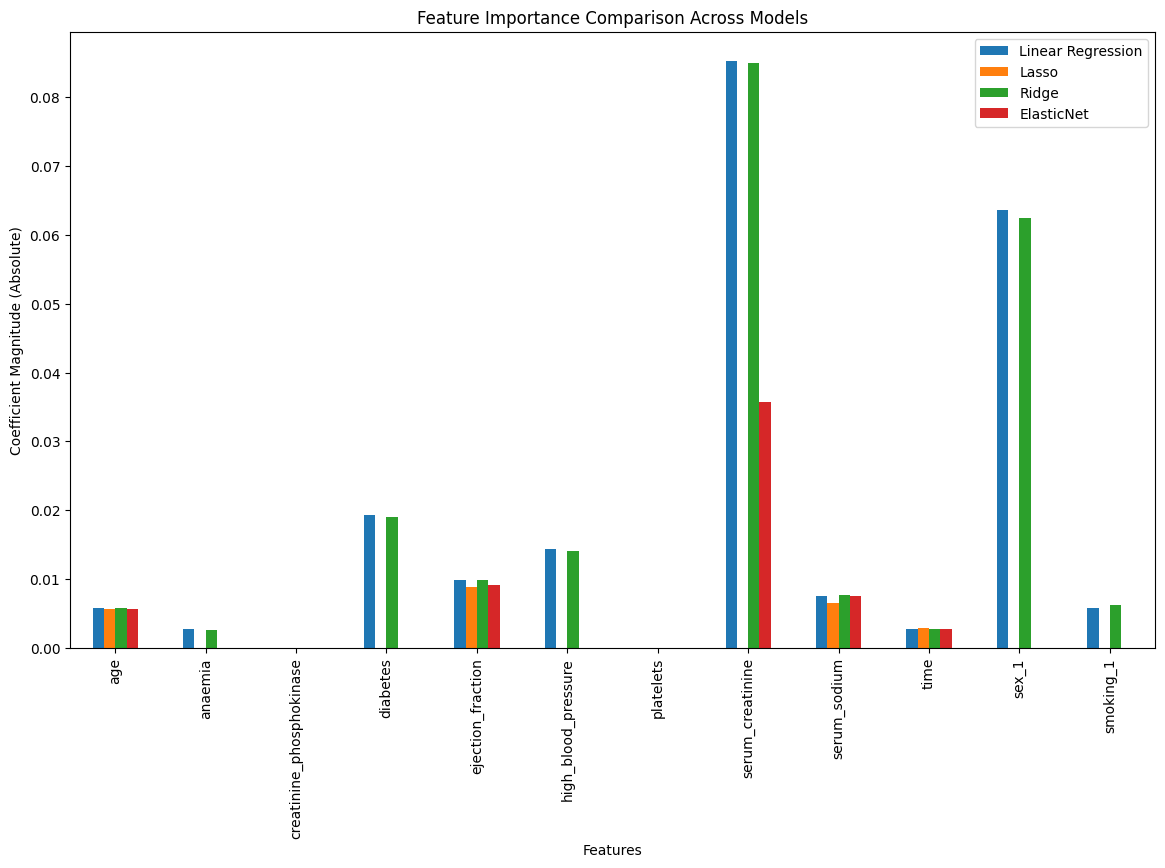

In [92]:
feature_importance = pd.DataFrame({
    'Linear Regression': np.abs(linear_model.coef_),
    'Lasso': np.abs(lasso_model.coef_),
    'Ridge': np.abs(ridge_model.coef_),
    'ElasticNet': np.abs(elastic_net_model.coef_)
}, index=X.columns)

feature_importance.plot(kind='bar', figsize=(14, 8))
plt.title('Feature Importance Comparison Across Models')
plt.ylabel('Coefficient Magnitude (Absolute)')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

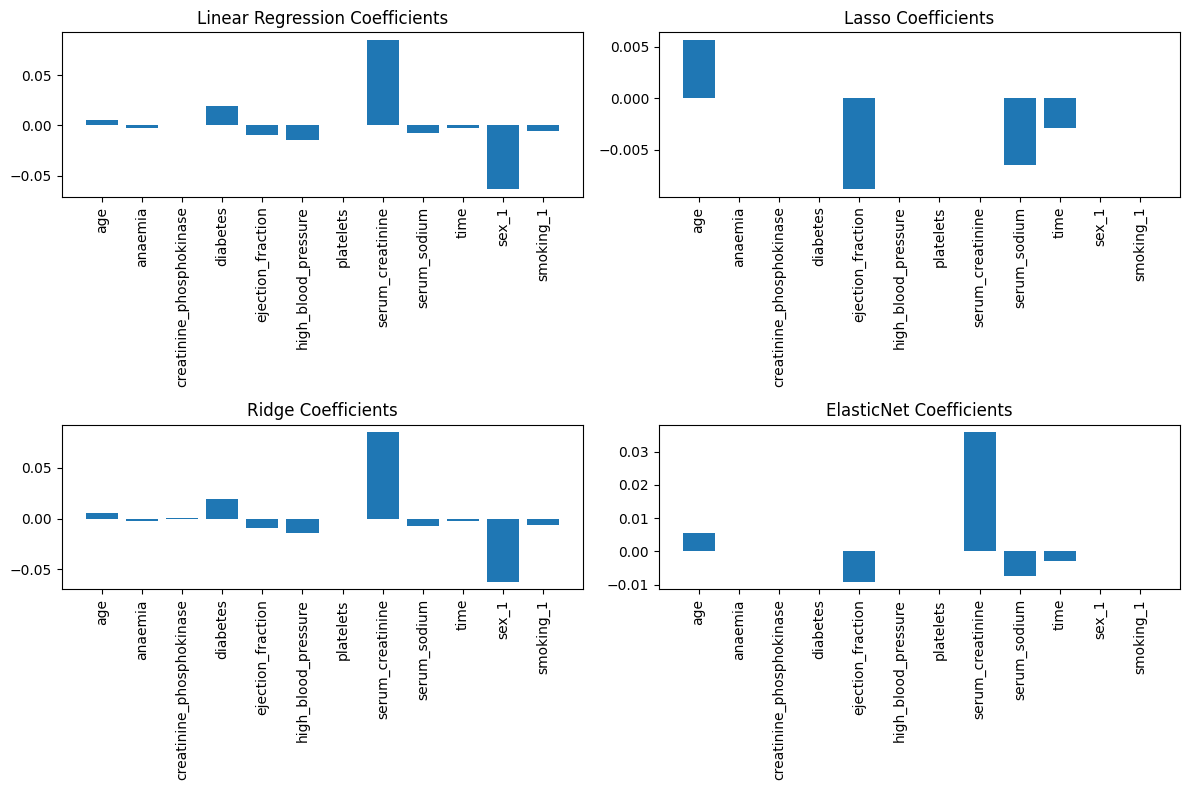

In [93]:
models_with_coeffs = {
    'Linear Regression': linear_model.coef_,
    'Lasso': lasso_model.coef_,
    'Ridge': ridge_model.coef_,
    'ElasticNet': elastic_net_model.coef_
}

plt.figure(figsize=(12, 8))
for i, (name, coeffs) in enumerate(models_with_coeffs.items(), 1):
    plt.subplot(2, 2, i)
    plt.bar(X.columns, coeffs)
    plt.title(f'{name} Coefficients')
    plt.xticks(rotation=90)
    plt.tight_layout()
plt.show()